# L3 Latencies, accesses by Core 0, Frequencies of Core 0 and 1 altered, Conway, I/O-Die in p-state P0

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import subprocess
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import pandas
from pylab import rcParams
import seaborn as sns

## Define functions

In [2]:
def savefig(name, **kwargs):
    fn = "{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [3]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, startstring, searchpara, retlist):

    searchpara = searchpara + "\""
    
    for file in filelist:
        for line in open(file):
            if line.startswith(startstring):
                if searchpara in line:
                    retlist.append(file)

In [4]:
def read_file(file):
    coreline = "BENCHIT_KERNEL_CPU_LIST=\"0\""

    core_found = False
    data_found = False
    
    rows = []
    
    for line in open(file):
        if line.startswith('comment='):
            regex = r"comment=\"Core0 at (?P<freq0>\d*)MHz, Core1 at (?P<freq1>\d*)MHz\""
            matches = re.search(regex, line)
            
            if matches:
                freq0 = int(matches.groupdict()["freq0"])
                freq1 = int(matches.groupdict()["freq1"])
                

        # check if file has data for core
        if line.startswith(coreline):
            core_found = True

        # data begins after "beginofdata" string, only search for this when coreline has been found in file
        if line.startswith("beginofdata") and core_found == True:
            data_found = True
            continue

    
        # append data to values array, make sure that no strings are appended
        if data_found == True and not line.startswith("endofdata") and not line.startswith("beginofdata"):

            # data for core 0 is taken from file that contains data for cores 0,1
            # data for core 0 can be found in col. index 1, every other core in col. index 2
            
            latency = float(line.split()[2])
            size = str(line.split()[0])
            
            rows.append({
                "core0_freq": freq0,
                "core1_freq": freq1,
                "latency_ns": latency,
                "latency_cycle": latency * freq0 / 1000,
                "size": size,
            })
            
    return rows

## Create file lists

In [5]:
# get list of all files in directory
paths = ['datafiles-base_1500MHz', 'datafiles-base_2200MHz', 'datafiles-base_2500MHz' ]

filelist = [],[],[]

for index, path in enumerate(paths):
    for entry in os.scandir(path):
        filelist[index].append(entry.path)


In [6]:
files = [],[],[] # 0 = M, 1 = (E|U), 2 = S, 3 = E, 4 = I
state = 'M'

for index, path in enumerate(paths):
    listgenerator(filelist[index], 'BENCHIT_KERNEL_USE_MODE', state, files[index])

    print("Files in list for state " + str(state) + ": " + str(len(files[index])))

Files in list for state M: 90
Files in list for state M: 90
Files in list for state M: 90


## Process data

In [7]:
size = '3.26407e+06'

_freq0 = "Frequency of Reading Core [GHz]"
_freq1 = "Frequency of Remaining Cores"
_latency = "Latency [ns]"


df = pandas.DataFrame()

for file in files[0]:
    rows = read_file(file)   
    df = df.append(rows, ignore_index=True)
  
df[_freq0] = df.core0_freq / 1000
#df[_freq1] = df.core1_freq / 1000
df[_latency] = df.latency_ns

df[_freq1] = df.core1_freq.apply(lambda x: {
    1500: "1.5 GHz",
    2200: "2.2 GHz",
    2500: "2.5 GHz",
}[x])

df = df[df["size"] == size]

df

,core0_freq,core1_freq,latency_ns,latency_cycle,size,Frequency of Reading Core [GHz],Latency [ns],Frequency of Remaining Cores
1,2200,2200,17.2021,37.84462,3.26407e+06,2.2,17.2021,2.2 GHz
7,1500,2200,22.0025,33.00375,3.26407e+06,1.5,22.0025,2.2 GHz
13,2200,2200,17.2011,37.84242,3.26407e+06,2.2,17.2011,2.2 GHz
19,2500,1500,15.2016,38.00400,3.26407e+06,2.5,15.2016,1.5 GHz
25,2200,1500,17.2035,37.84770,3.26407e+06,2.2,17.2035,1.5 GHz
...,...,...,...,...,...,...,...,...
511,2500,2200,15.2013,38.00325,3.26407e+06,2.5,15.2013,2.2 GHz
517,2500,2200,15.2002,38.00050,3.26407e+06,2.5,15.2002,2.2 GHz
523,2200,2200,17.6014,38.72308,3.26407e+06,2.2,17.6014,2.2 GHz
529,2500,2200,15.2009,38.00225,3.26407e+06,2.5,15.2009,2.2 GHz


## Plot Data

In [12]:
sns.set_context("paper") # doesn't work, rc={"figure.figsize": (5,5)})
rcParams['figure.figsize'] = 6, 3.2
parameters = {
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.fontsize' : 12,
          'legend.title_fontsize' : 12,}
plt.rcParams.update(parameters)

saving and cropping  ../../paper/fig/AMD-EPYC-7502-ns-L3-latencies-io_P0-L3_64B_aligned-reduced-crop.pdf


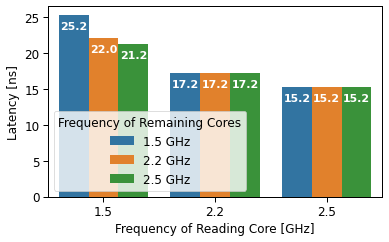

In [13]:
data = df.loc[df.groupby(['core0_freq', 'core1_freq']).latency_ns.idxmin()]


graph = sns.barplot(x=_freq0, y=_latency, hue=_freq1, data=data)

for p in graph.patches:
        graph.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.135, p.get_height()-1.5),
                    ha='center', va='center',
                    color= 'white', fontsize='11',fontweight='bold')

plt.legend(loc='lower left',title ='Frequency of Remaining Cores', fontsize='12', title_fontsize='12')



savefig("AMD-EPYC-7502-ns-L3-latencies-io_P0-L3_64B_aligned-reduced-crop")
